# Auto Sklearn

## Installing

- NOTE: -

WINDOWS
- auto-sklearn relies heavily on the Python module resource. resource is part of Python’s Unix Specific Services and not available on a Windows machine. Therefore, it is not possible to run auto-sklearn on a Windows machine.

MAC OS X
- We currently do not know if auto-sklearn works on OSX. There are at least two issues holding us back from actively supporting OSX

LINUX
- use the below way

In [0]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

## Time to Use

In [0]:
import sys,tempfile, urllib, os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
BASE_DIR = '/tmp'
OUTPUT_FILE = os.path.join(BASE_DIR, 'churn_data.csv')

In [0]:
churn_data=urllib.request.urlretrieve('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv', OUTPUT_FILE)

In [0]:
churn_df = pd.read_csv(OUTPUT_FILE)

In [32]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
churn_df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

# Data Cleaning 

- Ahem, Ahem. Auto Sklearn will not clean the data for you.
- You need to clean it yourself.
- You need to convert string data to numerical values.
- It will not accept string values. Nor will it handle it.

In [0]:
churn_df = churn_df.replace(r'^\s*$', np.nan, regex=True)

In [35]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
churn_df.iloc[: ,19] = pd.to_numeric(churn_df.iloc[:, 19], errors='coerce')

In [37]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

In [0]:
churn_df.iloc[:, 19] = imp_median.fit_transform(churn_df.iloc[:, 19].values.reshape(-1, 1))

In [0]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

In [0]:
categorical_columns = ['gender', 'Partner', 'Dependents','PhoneService','MultipleLines','InternetService',
                       'OnlineSecurity','OnlineBackup','DeviceProtection',
                       'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']

In [0]:
column_trans = make_column_transformer((OrdinalEncoder(), categorical_columns))

In [0]:
churn_transformed = column_trans.fit_transform(churn_df)

In [0]:
churn_df_trans = churn_df.copy()
churn_df_trans = pd.DataFrame(churn_transformed, columns=categorical_columns).astype(int)

In [0]:
churn_df.update(churn_df_trans)

In [46]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [0]:
churn_df_y = pd.DataFrame(churn_df['Churn'])
churn_df_x = churn_df.drop(['Churn'], axis=1, inplace=False)

In [0]:
churn_df_y['Churn'] = churn_df_y['Churn'].astype(np.int32) 

In [0]:
churn_df_x.drop(['customerID'], axis=1, inplace=True)

In [0]:
for cols in churn_df_x.columns:
    churn_df_x[cols] = churn_df_x[cols].astype(np.float32) 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(churn_df_x, churn_df_y, train_size=0.75, test_size=0.25, stratify=churn_df_y, random_state=31)

# Using the autosklearn module

In [0]:
import autosklearn.classification

Parameters to give
- time_left_for_task = time given for auto ml to do its job
- include estimators = algos that you want to execute
- exclude estimators = algos that you want to exclude
- include_preprocessors = denotes the preprocessing such as PCA. It does not preprocess the data like encoding or as such.
- per_run_time_limit = time limit per algorithm run.
- n_jobs = no of parallel processing threads that are required.
- exclude_preprocessirs = preprocessors that we do not want to take.


In [0]:
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=120, per_run_time_limit=30, n_jobs=2,
    include_estimators=["random_forest", "sgd", ], exclude_estimators=None, include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None)

In [57]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)
/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py:887: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self._check_y(y)


[WARNING] [2020-03-22 09:13:17,029:EnsembleBuilder(1791095845):2cf7bcc92738a432cb88ea401fb583a2] No models better than random - using Dummy Score!
[WARNING] [2020-03-22 09:13:17,058:EnsembleBuilder(1791095845):2cf7bcc92738a432cb88ea401fb583a2] No models better than random - using Dummy Score!


AutoSklearnClassifier(delete_output_folder_after_terminate=False,
                      delete_tmp_folder_after_terminate=False,
                      disable_evaluator_output=False,
                      ensemble_memory_limit=1024, ensemble_nbest=50,
                      ensemble_size=50, exclude_estimators=None,
                      exclude_preprocessors=None, get_smac_object_callback=None,
                      include_estimators=['random_forest', 'sgd'],
                      include_preprocessors=['no_preprocessing'],
                      initial_configurations_via_metalearning=25,
                      logging_config=None, metadata_directory=None,
                      ml_memory_limit=3072, n_jobs=2, output_folder=None,
                      per_run_time_limit=30, resampling_strategy='holdout',
                      resampling_strategy_arguments=None, seed=1,
                      shared_mode=False, smac_scenario_args=None,
                      time_left_for_this_task=120, tm

In [0]:
# Shows statistics about models trained
print(clf.show_models())

In [60]:
print(clf.sprint_statistics())

auto-sklearn results:
  Dataset name: 2cf7bcc92738a432cb88ea401fb583a2
  Metric: accuracy
  Best validation score: 0.810780
  Number of target algorithm runs: 112
  Number of successful target algorithm runs: 111
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



In [61]:
clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])]

{'balancing:strategy': 'none',
 'categorical_encoding:__choice__': 'no_encoding',
 'classifier:__choice__': 'sgd',
 'classifier:sgd:alpha': 0.05526828285460245,
 'classifier:sgd:average': 'True',
 'classifier:sgd:eta0': 0.010000000000000014,
 'classifier:sgd:fit_intercept': 'True',
 'classifier:sgd:learning_rate': 'constant',
 'classifier:sgd:loss': 'perceptron',
 'classifier:sgd:penalty': 'l2',
 'classifier:sgd:tol': 0.00018000937437560115,
 'imputation:strategy': 'most_frequent',
 'preprocessor:__choice__': 'no_preprocessing',
 'rescaling:__choice__': 'quantile_transformer',
 'rescaling:quantile_transformer:n_quantiles': 1489,
 'rescaling:quantile_transformer:output_distribution': 'uniform'}

In [0]:
predictions = clf.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score

In [66]:
print("Accuracy score : %s" %(accuracy_score(y_test, predictions)))

Accuracy score : 0.794434980124929


# Validating

In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [73]:
print(confusion_matrix(y_test, predictions))

[[1173  121]
 [ 241  226]]


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
sns.set()

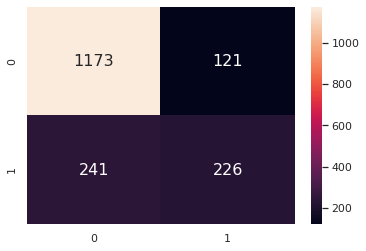

In [78]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predictions)), annot=True, annot_kws={"size": 16}, fmt='')
plt.show()

In [80]:
print(precision_score(y_test, predictions))

0.6512968299711815


In [81]:
print(recall_score(y_test, predictions))

0.48394004282655245


# Dumping using Pickle

In [0]:
import pickle

In [0]:
x = clf.show_models()

In [0]:
# Dumps the ensemble of models
my_model = {"ensemble" : x}

In [0]:
pickle.dump(my_model, open("model.pickle", 'wb'))

In [71]:
!ls *.pickle

model.pickle
